I begin by reading in and reworking the data. 
First letter of Cabin is indicative of the room in which the individual was staying.
Cleaning up the Name, titles like Mr., Miss., Mrs., etc are found.
For Fare and Age, I'm using buckets whose size is manually set so as to keep the buckets of a similar size. This prevents outliers from affecting the data too much in these columns. 
Also Fare and even Age are discreet quantities from the dataset, so interpreting them as continuous numbers doesn't add much.
Cleaning up the Ticket gives us an indication of the ticket class.
I delete Name, PassengerId, Ticket.

I apply these steps on train and test data, then I combined these in one frame and extend the categorical columns into One hot encoding format by using the pd.dummies utility function.

Then I split the data back into original train/test set and save the target variable. Then I tried two approaches - One where I delete the Age and Fare columns. The idea is that the bucketing contains all the information from these columns.

In the other approach I preserve these columns and use an imputer to infer the missing age values. 
(Both these approaches yield similar accuracy on a validation split)

I then scale and zero center the data using the minmaxscaler from scikitlearn.

I first tried a random forest classifier with default parameters. This yielded a kaggle score of 0.746.
Then I manually tweaked the parameters to avoid overfitting by increasing n_parameters, decreasing max_features, decreasing max_depth, so on. This yielded me a slightly better kaggle score of .751.

I then decided to use 10 fold cross validation over the parameters of the random forest classifier. First, with a smaller set of parameters. This yielded a score of .779. 
Then I tried the cross validation over a larger set of parameters which further increased the score to 0.789. This took a lot of time to train on my laptop.

At this point I hit a wall, where I tried some ideas by looking at the on my local validation split(30% of original train set):
 - filtering out unimportant features using feature_importances from an overfitted random forest classifier and then training another rf classifier by crossvalidation. This didnt have a good accuracy.
 - I tried getting a high accuracy on the validation set by using a lot of different classifiers linear, svc, neural net, other decision trees, etc.
 
At this point I decided to combine(ensemble) a few of the classifiers (ada boosting,logistic regression,random forest, extra trees,etc) which had a decent accuracy. I did this with the VotingClassifier using a 'soft' vote. This showed decent accuracy on the validation set. This got a kaggle score of 0.779. 
Since this gave more options which could be modified as compared to the crossvalidated random forest, I decided to do a cross validation over a big parameter grid for all the individual classifiers (552960 total fits). This is still running and I think it will have a higher score than the previous best.

My kaggle profile - https://www.kaggle.com/varun01124

In [48]:
import numpy as np
import pandas as pd
import sklearn
from collections import Counter
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score,make_scorer
from sklearn.ensemble import VotingClassifier
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 12)

test_file = 'data/test.csv'
train_file = 'data/train.csv'
X = pd.read_csv(train_file)
T = pd.read_csv(test_file)

Populating the interactive namespace from numpy and matplotlib


In [32]:
print X.shape
print T.shape

(891, 12)
(418, 11)


In [33]:
def cabin_cat(cab):
    if not pd.isnull(cab):
        return cab[0]
    else:
        return 'none'

def name_title(nm):
    wrds = nm.split(' ')
    tt = ''
    for ec in wrds:
        if ec[-1] == '.':
            return ec


def ticket_class(t):
    try:
        k = int(t)
        return 'non'
    except:
        k = t.split(' ')[0]
        return k.split('/')[0]

def real_from_estimate(age):
    if not pd.isnull(age):
        frac = float(age) - int(age)
        if int(age) > 0 and frac == 0.5:
            return float(int(age))
        else:
            return float(age)
    else:
        return age

def age_buckets(age):
    if not pd.isnull(age):
        if age<=5:
            return 1
        if 5<age<=10:
            return 2
        if 10<age<=15:
            return 3
        if 15<age<=17:
            return 4
        if 17<age<=19:
            return 5
        if 19<age<=21:
            return 6
        if 21<age<=23:
            return 7
        if 23<age<=25:
            return 8
        if 25<age<=27:
            return 9
        if 27<age<=29:
            return 10
        if 29<age<=31:
            return 11
        if 31<age<=33:
            return 12
        if 33<age<=35:
            return 13
        if 35<age<=37:
            return 14
        if 37<age<=42:
            return 15
        if 42<age<=47:
            return 16
        if 47<age<=52:
            return 17
        if 52<age<=60:
            return 18
        if 60<age:
            return 19
    else:
        return 0

def fare_buckets(f):
    if not pd.isnull(f):
        if f==0:
            return 0
        if 0<f<=7:
            return 1
        if 7<f<=7.23:
            return 2
        if 7.23<f<=7.742:
            return 3
        if 7.742<f<=7.888:
            return 4
        if 7.888<f<=8.03:
            return 5
        if 8.03<f<=10.463:
            return 6
        if 10.463<f<=18:
            return 7
        if 18<f<=25.93:
            return 8        
        if 25.93<f<=50:
            return 9
        if 50<f:
            return 10
    else:
        return 11
        
def features_modification(df):
    df['Cabin'] = df.Cabin.apply(cabin_cat)
    df['Title'] = df.Name.apply(name_title)
    df['Tclass'] = df.Ticket.apply(ticket_class)
    df['Age'] = df.Age.apply(real_from_estimate)
    df['Agebucket'] = df.Age.apply(age_buckets)
    df['Farebucket'] = df.Fare.apply(fare_buckets)

test_passengerids = T.PassengerId    
features_modification(X)
features_modification(T)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10b39f250>]], dtype=object)

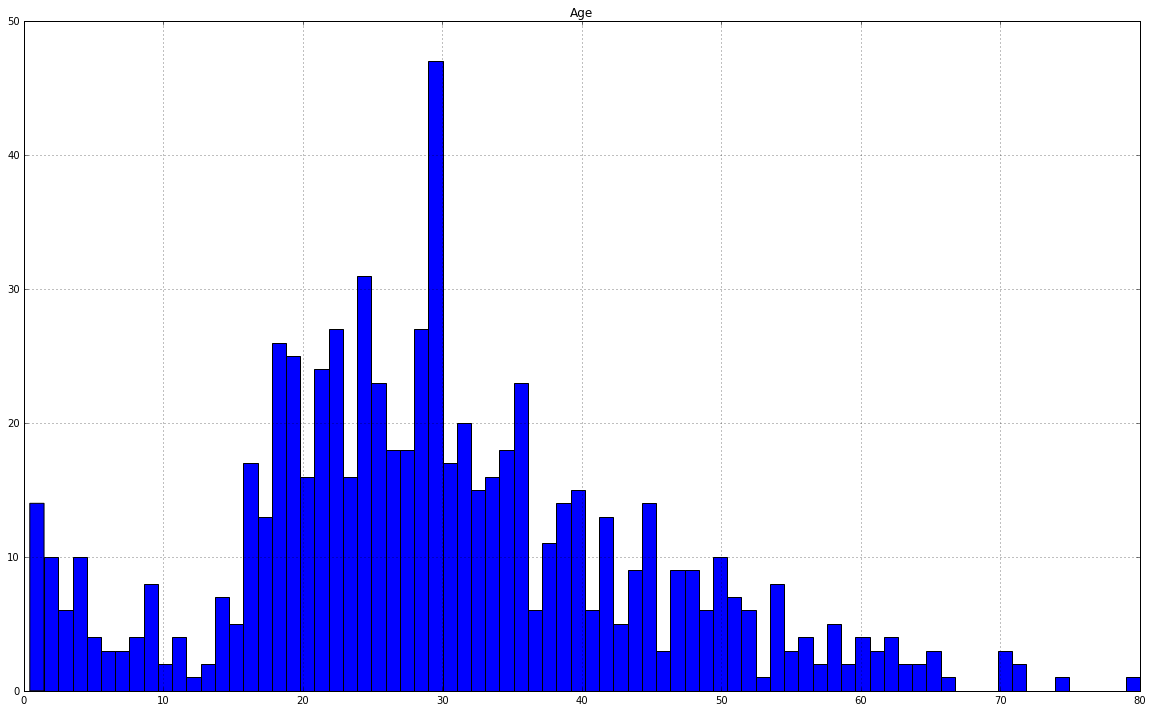

In [34]:
X.hist(column='Age',bins=78)

In [35]:
print Counter(X.Farebucket)
print Counter(X.Agebucket)

Counter({9: 166, 7: 163, 10: 160, 6: 97, 4: 79, 8: 63, 5: 57, 2: 42, 3: 36, 0: 15, 1: 13})
Counter({0: 177, 15: 59, 8: 54, 5: 51, 10: 47, 1: 44, 11: 44, 7: 43, 6: 40, 16: 40, 17: 38, 9: 36, 12: 35, 13: 34, 4: 30, 14: 29, 18: 29, 19: 22, 2: 20, 3: 19})


Next we see a correlation between survival and farebuckets and agebuckets.

In [36]:
grpd = X.groupby('Survived')

Survived
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: Farebucket, dtype: object

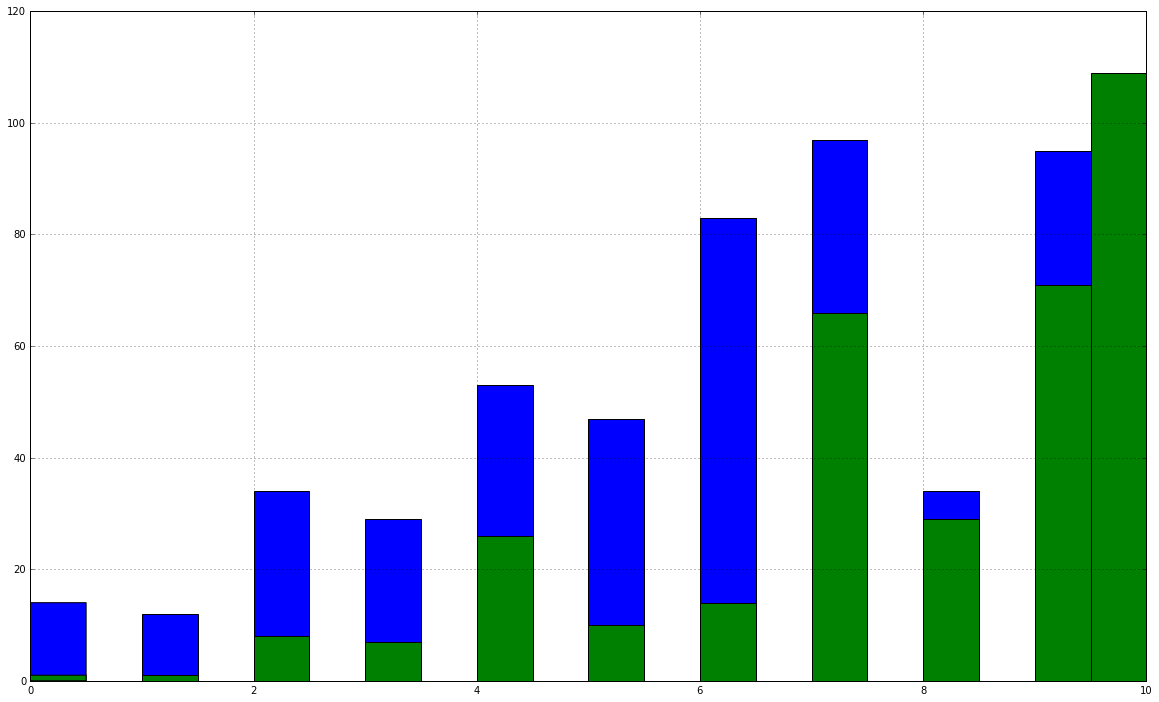

In [37]:
#not a stacked chart, just both cases being overlapped but the pattern can be seen, expensive 
#ticket increases chance of survival
grpd.Farebucket.hist(bins=20)

Survived
0    Axes(0.125,0.125;0.775x0.775)
1    Axes(0.125,0.125;0.775x0.775)
Name: Agebucket, dtype: object

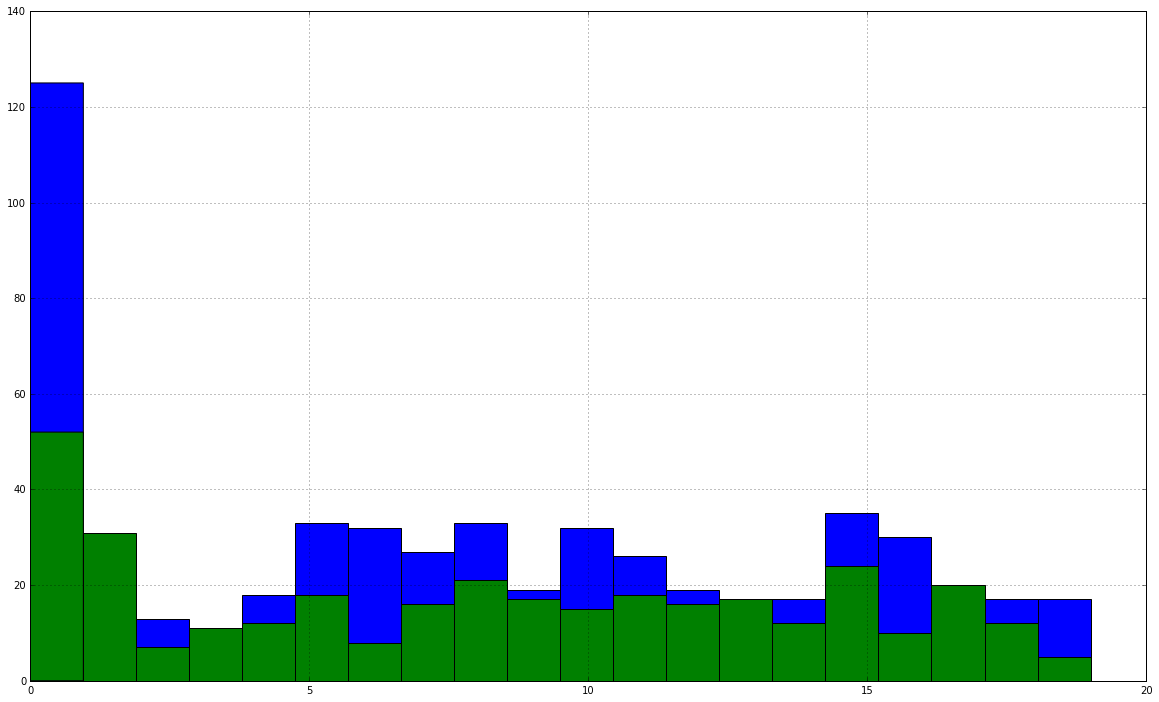

In [38]:
#not a stacked chart, just both cases being overlapped
grpd.Agebucket.hist(bins=20)

In [91]:
grpd.Tclass.value_counts()

Survived  Tclass
0         non       407
          A          22
          PC         21
          C.A.       15
          SOTON      15
          STON       10
          W.          8
          CA.         7
          CA          6
          SC          6
          S.O.C.      5
          C           3
          LINE        3
          S.O.        3
          A.          2
          A.5.        2
          S.C.        2
          A4.         1
          F.C.        1
          F.C.C.      1
          Fa          1
          P           1
          PP          1
          S.O.P.      1
          S.P.        1
          SCO         1
          W           1
          W.E.P.      1
          WE          1
1         non       254
          PC         39
          C.A.       13
          STON        8
          SC          7
          F.C.C.      4
          A           2
          C           2
          PP          2
          SOTON       2
          CA.         1
          LINE        1

In [39]:
print X.columns
print T.columns


# X.to_csv('./data/train_processed.csv',index=False)

T['PassengerId'] = test_passengerids
# T.to_csv('./data/test_processed.csv',index=False)
T.drop(['PassengerId','Name','Ticket'],inplace=True,axis=1)
y = X.Survived
X.drop(['Survived','PassengerId','Name','Ticket'],inplace=True,axis=1)
print X.columns
print T.columns
print len(X.columns)
print len(T.columns)

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked', u'Title',
       u'Tclass', u'Agebucket', u'Farebucket'],
      dtype='object')
Index([u'PassengerId', u'Pclass', u'Name', u'Sex', u'Age', u'SibSp', u'Parch',
       u'Ticket', u'Fare', u'Cabin', u'Embarked', u'Title', u'Tclass',
       u'Agebucket', u'Farebucket'],
      dtype='object')
Index([u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare', u'Cabin',
       u'Embarked', u'Title', u'Tclass', u'Agebucket', u'Farebucket'],
      dtype='object')
Index([u'Pclass', u'Sex', u'Age', u'SibSp', u'Parch', u'Fare', u'Cabin',
       u'Embarked', u'Title', u'Tclass', u'Agebucket', u'Farebucket'],
      dtype='object')
12
12


In [40]:
combined = X.append(T)
combined.reset_index(inplace=True)

# this was an idea to impute the missing ages by getting median of ages grouped by sex,pclass and title
# combined["Age"] = combined.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median())) - 

combined.drop('index',inplace=True,axis=1)

In [41]:
combined['Age'] = combined.Age.apply(real_from_estimate)

In [42]:
combined = pd.get_dummies(combined,columns = [u'Pclass', u'Sex', u'SibSp', u'Parch', u'Cabin',
       u'Embarked', u'Title', u'Tclass'])

In [43]:
combined.shape

(1309, 88)

In [44]:
X = combined.loc[0:890,:]
T = combined.loc[891:,:]
print X.columns
print T.columns
print X.shape
print T.shape
# training and test data now have the same columns
print set(X.columns) - set(T.columns)


Index([            u'Age',            u'Fare',       u'Agebucket',
            u'Farebucket',        u'Pclass_1',        u'Pclass_2',
              u'Pclass_3',      u'Sex_female',        u'Sex_male',
               u'SibSp_0',         u'SibSp_1',         u'SibSp_2',
               u'SibSp_3',         u'SibSp_4',         u'SibSp_5',
               u'SibSp_8',         u'Parch_0',         u'Parch_1',
               u'Parch_2',         u'Parch_3',         u'Parch_4',
               u'Parch_5',         u'Parch_6',         u'Parch_9',
               u'Cabin_A',         u'Cabin_B',         u'Cabin_C',
               u'Cabin_D',         u'Cabin_E',         u'Cabin_F',
               u'Cabin_G',         u'Cabin_T',      u'Cabin_none',
            u'Embarked_C',      u'Embarked_Q',      u'Embarked_S',
           u'Title_Capt.',      u'Title_Col.', u'Title_Countess.',
            u'Title_Don.',     u'Title_Dona.',       u'Title_Dr.',
       u'Title_Jonkheer.',     u'Title_Lady.',    u'Title_Majo

In [45]:
from sklearn import ensemble,preprocessing
age_imp = preprocessing.Imputer(strategy='most_frequent')
# scaler = preprocessing.StandardScaler()
scaler = preprocessing.MinMaxScaler((-1,1))

tr_X = np.array(X)
tr_y = np.array(y)
tst_X = np.array(T)

#imputing age values
tr_X = age_imp.fit_transform(tr_X)
tst_X = age_imp.transform(tst_X)

#scaling and zero centering
tr_X = scaler.fit_transform(tr_X)
tst_X = scaler.transform(tst_X)

In [ ]:
rf = ensemble.RandomForestClassifier(n_estimators=100,max_depth=50,class_weight='balanced')
rf.fit(tr_X,tr_y)
print 'Score ' + str(rf.score(tr_X,tr_y))

#feature importances 
feats = []
for idx,ec in enumerate(X.columns):
    feats.append((ec,100*rf.feature_importances_[idx],idx))
feats.sort(key=lambda x:x[1],reverse=True)
#print feats

In [53]:
def predict_store(tst_X,passengerids,clf,submission_number):
    preds = clf.predict(tst_X)
    sub = pd.DataFrame()
    sub['PassengerId'] = passengerids
    sub['Survived'] = preds
    sub.to_csv('./submissions/{}.csv'.format(submission_number),index=False)

In [ ]:
clf = RandomForestClassifier()
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(tr_X,tr_y,test_size=0.3,random_state=0)

#test a classifier against the validation set - not important for this cv but for quickly trying out different 
#classifiers
def test_individual(clf,tr_X,tr_y,tst_X,tst_y):
    clf.fit(tr_X,tr_y)
    print clf.score(tst_X,tst_y)
    
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

#one of the high scoring grids
param_grid = {"max_depth": [5,7],
              "n_estimators":[50,100,200],
              "max_features": [20],
              "min_samples_leaf": [1,5,10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

grid_search = GridSearchCV(clf, param_grid=param_grid,n_jobs=-1,cv=10,verbose=True)
start = time()
grid_search.fit(tr_X,tr_y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

In [54]:
#predicting with the best grid_search classifier and storing it for submission
#predict_store(tst_X,test_passengerids,grid_search,'rf4') 

In [20]:
#Some of the models tried 
rf = RandomForestClassifier(bootstrap=False, class_weight=None,
            criterion='entropy', max_depth=7, max_features=20,
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

mlp = MLPClassifier(activation='relu', alpha=0.00001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5,2), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=20000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

gdb = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=10, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=9,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=1000, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

ada = ensemble.AdaBoostClassifier()
bgg = ensemble.BaggingClassifier()
gaup = sklearn.gaussian_process.GaussianProcessClassifier()
svc_1 = sklearn.svm.SVC(probability=True)
# svc_2 = sklearn.svm.LinearSVC()
# svc_3 = sklearn.svm.NuSVC(probability=True)
dt = sklearn.tree.DecisionTreeClassifier()
pa = sklearn.linear_model.PassiveAggressiveClassifier()
rdg = sklearn.linear_model.RidgeClassifier()
sdg = sklearn.linear_model.SGDClassifier(loss='log')
lr = sklearn.linear_model.LogisticRegression()
et = ExtraTreesClassifier(n_estimators=2000, max_depth=15, min_samples_split=3, random_state=0)
gnb = GaussianNB()

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.cross_validation import train_test_split,StratifiedShuffleSplit,StratifiedKFold

X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(tr_X,tr_y,test_size=0.2)
# eclf = VotingClassifier(estimators=[('ada',ada),('lr',lr),('rf',rf),('sdg',sdg),('et',et),('mlp',mlp),('gdb',gdb)],
#                         weights = [1.5,1.5,2.5,0.13,1.5,1.5,1.5], voting='soft')
eclf = VotingClassifier(estimators=[('ada',ada),('lr',lr),('rf',rf),('et',et),('gdb',gdb),('gnb',gnb)],
                         weights = [1.5,1.5,2.5,1.5,1.5,1.5], voting='soft')

param_grid = {'ada__n_estimators':[10,100],'ada__learning_rate':[.01,.001],
              'lr__C':[0.1,1],'lr__class_weight':['balanced'],
              'rf__n_estimators':[100,400],'rf__max_features':[5,10,'auto'],'rf__max_depth':[10,5],
              'rf__min_samples_split':[5,50],
              'et__n_estimators':[100,400],'et__max_features':[5,10,'auto'], 'et__max_depth':[10,5],
              'et__min_samples_split':[5,50],
              'gdb__loss':['deviance', 'exponential'],'gdb__learning_rate':[0.01, 0.001,0.1],
              'gdb__min_samples_split':[5,10]}}
grid_search = GridSearchCV(eclf, param_grid=param_grid, verbose=3,scoring='accuracy',
cv=StratifiedShuffleSplit(y_train, n_iter=10, test_size=0.2, train_size=None, 
random_state=0)).fit(X_train, y_train)
# [0.5,0.05,0.01,1.0]
# (('dt',dt),('gaup',gaup),('gnb',gnb),('bgg',bgg))
test_individual(grid_search,X_train,y_train,X_test,y_test)

#fitting with whole training data before creating submission
grid_search.fit(tr_X,tr_y)

#This model is still training

In [188]:
#predict_store(tst_X,test_passengerids,grid_search,'ensemble_long')